# OptiMask: Efficient Python Package for NaN Data Removal

Introducing OptiMask, a Python package designed to simplify the process of removing NaN (Not-a-Number) data from matrices while efficiently computing the largest (and non necessarily contiguous) submatrix without NaN. OptiMask focuses on providing immediate results, seamless compatibility with both Numpy arrays and Pandas DataFrames, and a user-friendly experience.

Highlights:

- NaN Data Removal: OptiMask streamlines the removal of NaN data from matrices, ensuring data integrity.
- Largest Submatrix: OptiMask computes the largest submatrix without NaN, enhancing data analysis accuracy.
- Swift Computation: With its fast computation, OptiMask swiftly generates results without unnecessary delays.
- Numpy and Pandas: Whether you use Numpy or Pandas, OptiMask adapts to your preferred data structure.
- Simplicity: OptiMask boasts a straightforward Python interface, making it easy for users of all levels to navigate.


Cyril Joly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optimask import OptiMask

In [2]:
def plot(data, figsize=None, title=None, show=True):
    cmap = plt.get_cmap("Spectral_r")
    cmap.set_bad('grey')
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.pcolormesh(data, cmap=cmap)
    plt.gca().axis('off')
    plt.gca().set_aspect('equal')
    plt.title(title)
    if show:
        plt.show()


def plot_rectangle(xmin, ymin, xmax, ymax, ec='k'):
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=ec, facecolor='none')
    plt.gca().add_patch(rect)


def generate_random(m, n, ratio):
    arr = np.zeros((m, n))
    nan_count = int(ratio * m * n)
    indices = np.random.choice(m * n, nan_count, replace=False)
    arr.flat[indices] = np.nan
    return arr

# 1. Understanding the problem at hand

In the context of a matrix containing a lone NaN cell, the central challenge emerges: determining whether to eliminate the corresponding row or column. This decision is readily resolved by examining the matrix's shape. Specifically, if the matrix has a greater number of rows than columns, the optimal approach involves removing the associated row. Conversely, when the matrix has more columns than rows, the most effective course of action is to eliminate the corresponding column:

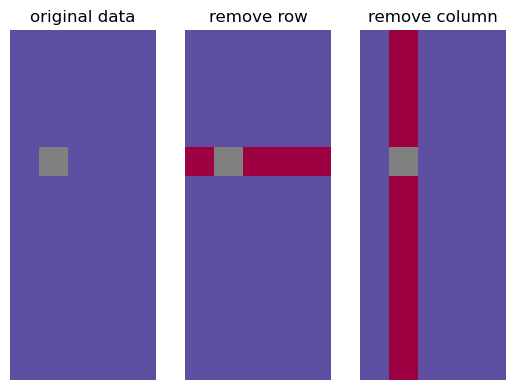

In [3]:
x = np.zeros((12, 5))
x[7, 1] = np.nan

x1 = x.copy()
x1[7] += 1

x2 = x.copy()
x2[:, 1] += 1

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x1, show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x2, show=False, title='remove column')
plt.show()

Eliminating the highlighted row yields the most extensive submatrix devoid of NaN. This solution remains optimal even when additional NaN values are present within the same row:

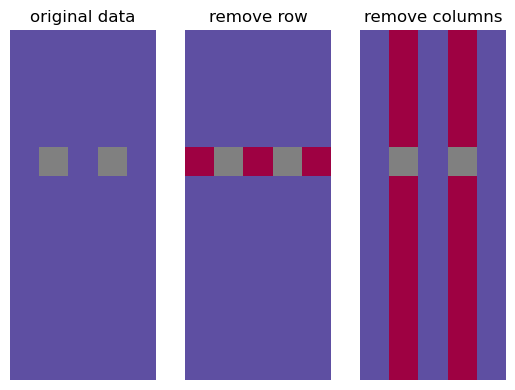

In [4]:
x = np.zeros((12, 5))
x[7, [1, 3]] = np.nan

x1 = x.copy()
x1[7] += 1

x2 = x.copy()
x2[:, [1, 3]] += 1

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x1, show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x2, show=False, title='remove columns')
plt.show()

But what about more complex cases ? 

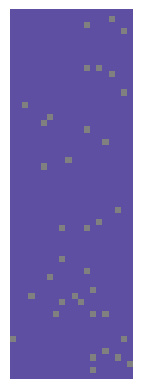

In [5]:
m, n = 60, 20
ratio = 0.03
x = generate_random(m, n, ratio)

plot(x)

## 2. The Problem from an Optimization Perspective

This problem can be formalized as a binary optimization problem in two ways.

### 2.1. Linear programming

Source : [this mathematica.stackexchange answer](https://mathematica.stackexchange.com/a/108513/92680), posted by [unlikely](https://mathematica.stackexchange.com/users/16267/unlikely).

Given:

- Matrix $A$ of shape $m \times n$ and elements $a_{i,j}$
- The goal is to determine the values of variables $(i \in [1~..~m]$, $j \in [1~..~n])$:
  - $e_{i,j} \in \{0,1\}$ (1 if element $(i,j)$ should be removed, 0 otherwise)
  - $r_i \in \{0,1\}$ (1 if row $i$ should be removed, 0 otherwise)
  - $c_j \in \{0,1\}$ (1 if column $j$ should be removed, 0 otherwise)



Subject to:


- $e_{i,j} = 1$ for every $(i,j)$ such that $a_{i,j}$ is a NaN
- $r_i + c_j \geq e_{i,j}$, meaning if $e_{i,j} = 1$ then either $r_i = 1$ or $c_j = 1$, or both
- $e_{i,j} \geq r_i$, indicating if $r_i = 1$ then $e_{i,j}$ must be 1
- $e_{i,j} \geq c_j$, indicating if $c_j = 1$ then $e_{i,j}$ must be 1

The objective is to minimize the total number of remaining cells:

$$\sum_{i=1}^{m} \sum_{j=1}^{n} e_{i,j}$$

The optimal values of $r_i$ and $c_j$ provide us with the specific rows and columns to remove, ensuring that the remaining matrix is efficiently processed and devoid of NaN values. This problem can be solved in Python using the usual tools of linear programming, such as combining Pyomo with GLPK. Its disadvantage is being relatively expensive, as for an $m \times n$ matrix, more than $m \times n$ (binary) variables are used.

CPU times: total: 344 ms
Wall time: 1.4 s


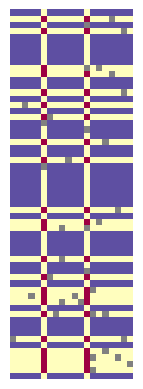

The largest submatrix without NaN is of size 37x18 (666 elements among 1200)


In [6]:
from pyomo.environ import Binary, ConcreteModel, Constraint, ConstraintList, Objective, SolverFactory, Var, minimize


def linear_programming(matrix):
    m, n = matrix.shape
    model = ConcreteModel()

    # Variables
    model.e = Var(range(1, m + 1), range(1, n + 1), within=Binary)
    model.r = Var(range(1, m + 1), within=Binary)
    model.c = Var(range(1, n + 1), within=Binary)

    # Objective
    model.obj = Objective(expr=sum(model.e[i, j] for i in range(1, m + 1) for j in range(1, n + 1)), sense=minimize)

    # Constraints
    positions = [(i, j) for i in range(1, m + 1) for j in range(1, n + 1)]
    nan_positions = [(i, j) for (i, j) in positions if np.isnan(matrix[i - 1, j - 1])]

    model.nan_constraints = ConstraintList()
    for i, j in nan_positions:
        model.nan_constraints.add(model.e[i, j] == 1)

    model.other_constraints = ConstraintList()
    for i, j in positions:
        model.other_constraints.add(model.r[i] + model.c[j] >= model.e[i, j])
        model.other_constraints.add(model.e[i, j] >= model.r[i])
        model.other_constraints.add(model.e[i, j] >= model.c[j])

    # Solve the model
    solver = SolverFactory('glpk')
    solver.solve(model)

    # Extract the results
    rows_to_keep = [i-1 for i in range(1, m + 1) if model.r[i].value == 0]
    cols_to_keep = [j-1 for j in range(1, n + 1) if model.c[j].value == 0]

    return rows_to_keep, cols_to_keep


%time rows, cols = linear_programming(x)
xt = x.copy()
xt[rows] -= 1
xt[:, cols] -= 1

plot(xt)
print(f"The largest submatrix without NaN is of size {len(rows)}x{len(cols)} ({len(rows)*len(cols)} elements among {xt.size})")

### 2.2. Quadratic Programming

By employing the variables mentioned earlier, an alternate perspective of the problem involves maximizing $$(m-\sum_{i=1}^m r_i) \times (n-\sum_{i=1}^n c_j)$$
while considering:
- $r_i + c_j \ge 1$ for each $(i,j)$ where $a_{i,j}$ is a NaN.

Although the number of variables is reduced, the optimization problem becomes more challenging.

# 3. OptiMask
## 3.1. The algorithm

OptiMask's algorithm presents a novel methodology for identifying an optimal set of rows and columns to be removed, with the objective of obtaining the largest submatrix without NaN values. It is crucial to highlight that, as of now, the formal proof of convergence for this algorithm remains unestablished.

The algorithm engages in iterative computations involving permutations of rows and columns until a specific convergence criterion is satisfied. This criterion relies on the detection of a contiguous and well-ordered NaN frontier, akin to a Pareto efficiency frontier. Once this frontier is identified, the problem simplifies to the determination of the largest contiguous rectangle, a computationally straightforward task. The stored row and column permutations subsequently facilitate the identification of the specific rows and columns to be removed.

It is important to emphasize that the heuristic nature of OptiMask's algorithm introduces a level of uncertainty regarding the optimality of the obtained result, particularly when juxtaposed with the linear programming approach. In an effort to increase the likelihood of reaching an optimal solution, the algorithm undergoes multiple optimizations through repeated restarts employing random permutations. The parameter `n_tries` governs the number of restarts, where a higher value is anticipated to improve the chances of attaining an optimal solution. Moreover, the random nature of these permutations is controlled by the `random_state` parameter, ensuring reproducibility across different runs of the algorithm.

Despite its heuristic character, OptiMask's algorithm demonstrates a notable acceleration in computational efficiency compared to the precise solution offered by the linear programming approach. The capability to conduct multiple restarts, guided by the `n_tries` and `random_state` parameters, enhances the algorithm's adaptability and resilience in seeking a satisfactory solution within a reasonable computational timeframe.

In [7]:
%%time
rows, cols = OptiMask(n_tries=35, verbose=True).solve(x)

28 rows and 18 columns contain NaNs.
	Trial 1 : submatrix of size 37x18 (666 elements) found.
	Trial 2 : submatrix of size 37x18 (666 elements) found.
	Trial 3 : submatrix of size 32x20 (640 elements) found.
	Trial 4 : submatrix of size 34x19 (646 elements) found.
	Trial 5 : submatrix of size 36x18 (648 elements) found.
	Trial 6 : submatrix of size 36x18 (648 elements) found.
	Trial 7 : submatrix of size 37x18 (666 elements) found.
	Trial 8 : submatrix of size 36x18 (648 elements) found.
	Trial 9 : submatrix of size 37x18 (666 elements) found.
	Trial 10 : submatrix of size 32x20 (640 elements) found.
	Trial 11 : submatrix of size 38x17 (646 elements) found.
	Trial 12 : submatrix of size 39x17 (663 elements) found.
	Trial 13 : submatrix of size 37x18 (666 elements) found.
	Trial 14 : submatrix of size 36x18 (648 elements) found.
	Trial 15 : submatrix of size 32x20 (640 elements) found.
	Trial 16 : submatrix of size 36x18 (648 elements) found.
	Trial 17 : submatrix of size 34x19 (646 ele

## 3.2. Speed of convergence

In [17]:
def cummax(arr):
    return np.array([max(arr[:i + 1]) for i in range(len(arr))])

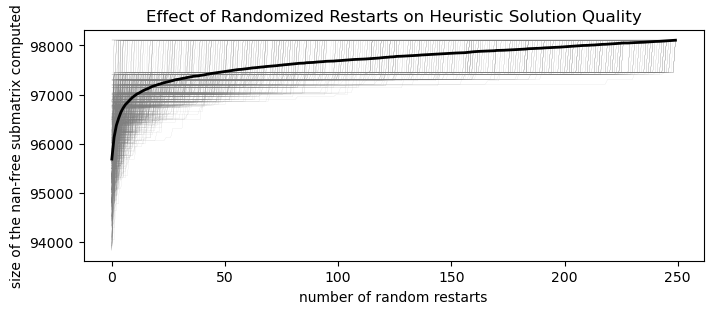

In [31]:
m, n = 8000, 40
ratio = 0.03
x = generate_random(m, n, ratio)

opti_mask = OptiMask(n_tries=1)

ret = []
for _ in range(250):
    rows, cols = opti_mask.solve(x)
    ret.append(len(rows)*len(cols))
ret = np.array(ret)

ret_mean = np.zeros_like(ret, dtype=float)

n_permutations = 1000
plt.figure(figsize=(8, 3))
for _ in range(n_permutations):
    ret_iter = cummax(ret[np.random.permutation(len(ret))])
    plt.plot(ret_iter, c='grey', lw=0.05)
    ret_mean += ret_iter/n_permutations
plt.plot(ret_mean, c='k', lw=2)
plt.xlabel('number of random restarts')
plt.ylabel('size of the nan-free submatrix computed')
plt.title("Effect of Randomized Restarts on Heuristic Solution Quality")
plt.show()

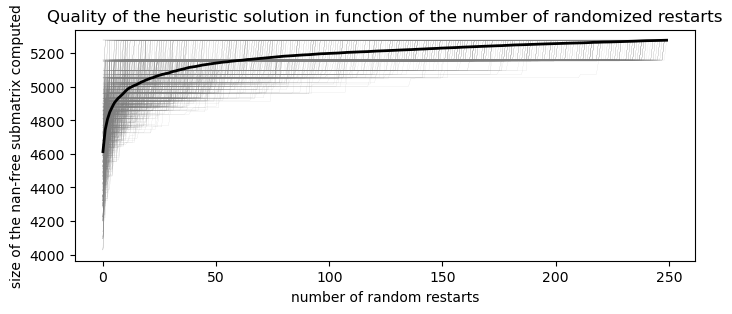

In [32]:
m, n = 500, 500
ratio = 0.05
x = generate_random(m, n, ratio)

opti_mask = OptiMask(n_tries=1)

ret = []
for _ in range(250):
    rows, cols = opti_mask.solve(x)
    ret.append(len(rows)*len(cols))
ret = np.array(ret)

ret_mean = np.zeros_like(ret, dtype=float)

n_permutations = 1000
plt.figure(figsize=(8, 3))
for _ in range(n_permutations):
    ret_iter = cummax(ret[np.random.permutation(len(ret))])
    plt.plot(ret_iter, c='grey', lw=0.05)
    ret_mean += ret_iter/n_permutations
plt.plot(ret_mean, c='k', lw=2)
plt.xlabel('number of random restarts')
plt.ylabel('size of the nan-free submatrix computed')
plt.title("Quality of the heuristic solution in function of the number of randomized restarts")
plt.show()